In [ ]:
!pip install -r requirements.txt

In [3]:
from pandas import set_option

def append_suffix(name: str, suffix: str) -> str:
    return f"{name.removesuffix('.parquet')}{suffix}.parquet"

set_option('display.max_columns', None)

## Remove unnecessary data

- remove non-TCP flows (https://en.wikipedia.org/wiki/List_of_IP_protocol_numbers)
- remove rows containing infinity/NaN values in numeric columns
- remove columns that contain low amount of unique values
- remove columns with high correlation

In [4]:
from pandas import read_parquet
from collections import Counter
from numpy import isfinite
import seaborn as sns
import matplotlib.pyplot as plt

file = 'data.parquet'

print(f"Reading file {file}")
df = read_parquet(file)
print(df.columns)

print(f"Starting dataframe shape: {df.shape}")
print(f"Counted rows by protocol: {Counter(df['Protocol'])}")
print("Removing non-TCP rows...")
df = df[df['Protocol'] == 6]

print("Remove 'DoS attacks-Slowloris' rows")

df = df[df['Label'] != 'DoS attacks-Slowloris']

print("Removing 'Protocol' and 'Timestamp' columns")
df.drop(columns=['Protocol', 'Timestamp'], inplace=True)

cols_to_remove = []

UNIQUE_VALUES_THRESHOLD = 10

for column in df:
    unique_vals = len(set(df[column]))
    print(f"column: '{column}', unique values: {unique_vals}")
    if unique_vals < UNIQUE_VALUES_THRESHOLD and column != 'Label':
        cols_to_remove.append(column)
        print(f"Removing column {column}")
        print(f"Column values: {Counter(df[column])}")

df.drop(columns=cols_to_remove, inplace=True)

print("Correlation matrix")
df_features = df.drop(columns=['Label'], inplace=False)

# removing rows with Inf/Nan values
finite_indexes = isfinite(df_features).all(1)
df_features = df_features[finite_indexes]
df = df[finite_indexes]

correlation_matrix = df_features.corr()

CORRELATION_THRESHOLD = 0.95

save_columns = []
drop_columns = []
for index, row in correlation_matrix.iterrows():
    for colname in correlation_matrix.columns:
        if colname == index:
            continue
        if colname in save_columns or colname in drop_columns:
            continue

        if abs(row[colname]) > CORRELATION_THRESHOLD and colname not in save_columns:
            drop_columns.append(colname)
            save_columns.append(index)
            print(f"Removing column {colname} as its corellation to {index} is {row[colname]}")

df.drop(columns=drop_columns, inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"""

###################################
Final data state for file {file}
Shape (rows, columns): {df.shape}
Label counts: {Counter(df['Label'])}
###################################

""")
df.to_parquet(append_suffix(file, '_pruned'))

Reading file data.parquet
Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Rati

### Initial orrelation matrix

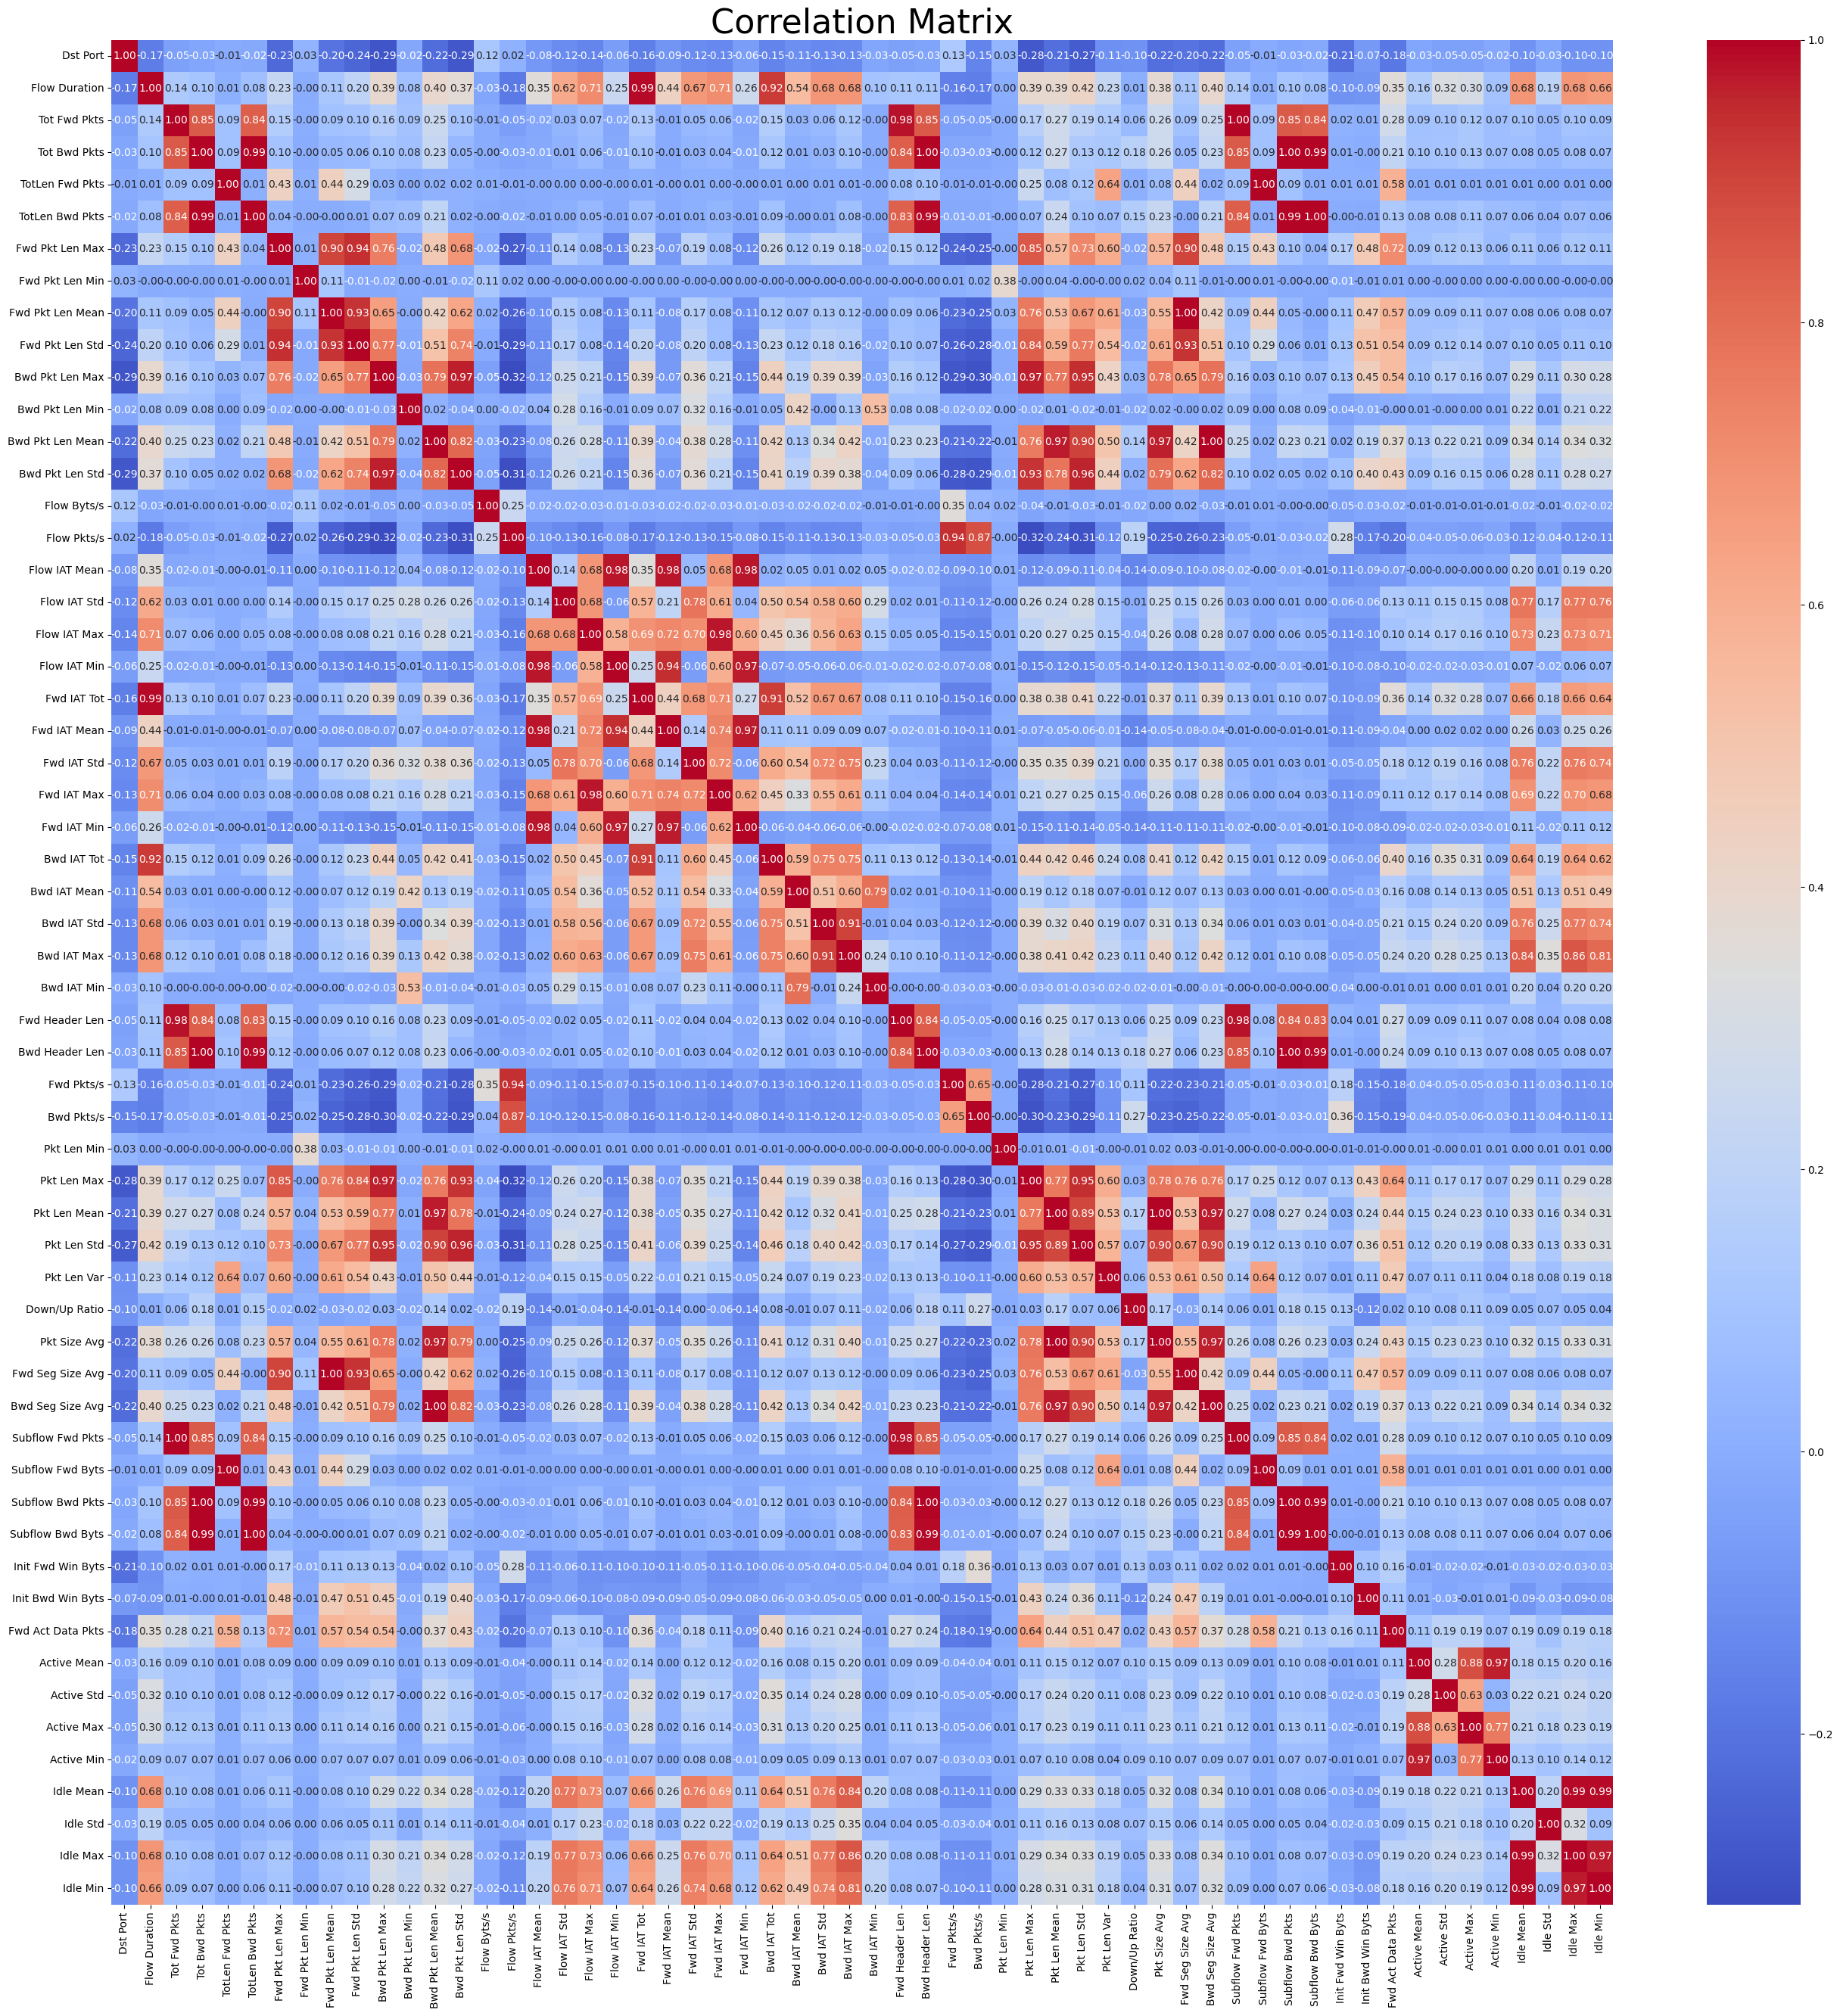

In [5]:
# Set up the matplotlib figure
plt.figure(figsize=(32, 32))

# Draw the heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

# Set the title of the heatmap
plt.title('Correlation Matrix', fontsize=32)

plt.savefig('correlation_matrix.png', dpi='figure', bbox_inches='tight', format="png")

### Final correlation matrix

(1490956, 37)


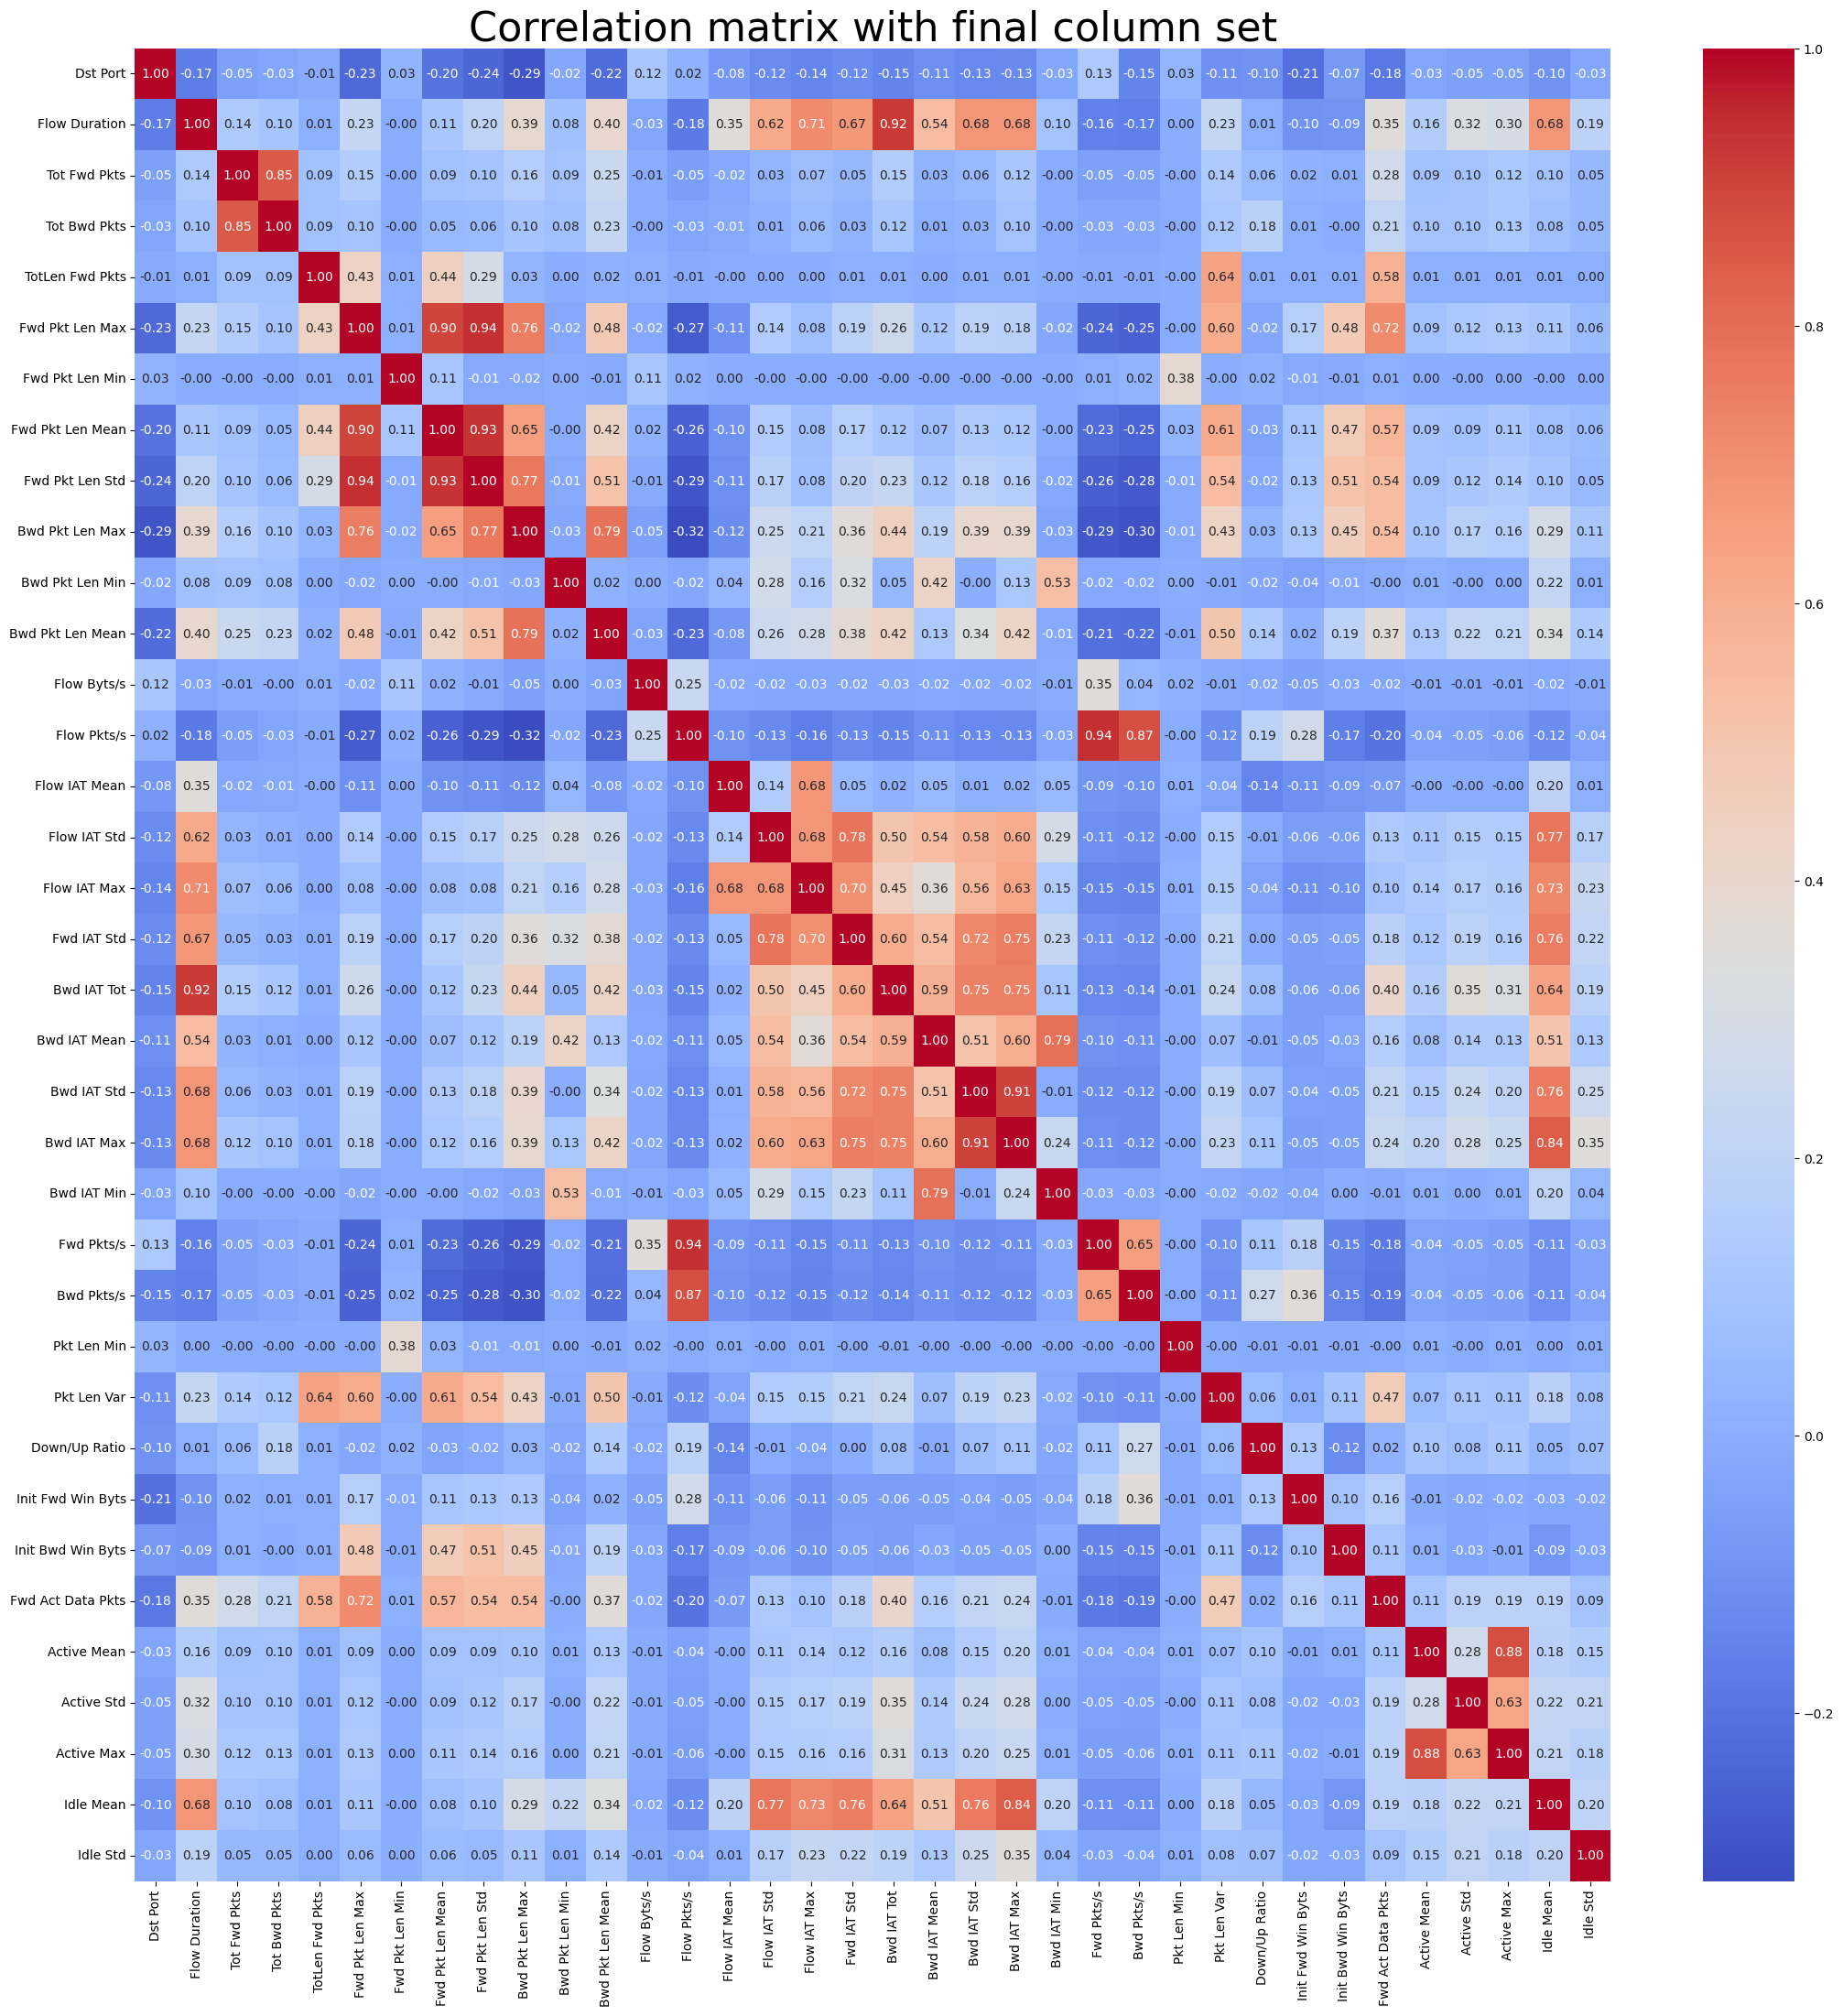

In [6]:
print(df.shape)
df_features = df.drop(columns=['Label'], inplace=False)

correlation_matrix = df_features.corr()

# Set up the matplotlib figure
plt.figure(figsize=(26, 26))

# Draw the heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

# Set the title of the heatmap
plt.title('Correlation matrix with final column set', fontsize=32)

plt.savefig('final_correlation_matrix.png', dpi='figure', bbox_inches='tight', format="png")

## Normalization

- use MinMaxScaler to normalize data
- save the fitted scaler to file, for usage on any new data to analyze

In [7]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from numpy import isfinite
from pickle import dump

file = "data_pruned.parquet"

print(f"Reading file {file}")
df = read_parquet(file)
df_features = df.drop(columns=['Label'], inplace=False)

scaler = MinMaxScaler()

normalized_features = DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

with open("min_max_scaler_fitted.pickle", 'wb') as file_output:
    dump(scaler, file_output)

# Combine the normalized numeric data with the non-numeric data
df = concat([normalized_features, df['Label']], axis=1, ignore_index=False)
print("Example row after normalization:")
# df = df.reset_index(drop=True)
print(df.head(1))
print(df.shape)
print("dtypes:")
print(df.dtypes)
df.to_parquet(append_suffix(file, '_normalized'))

Reading file data_pruned.parquet
Example row after normalization:
   Dst Port  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0  0.000259        0.31139      0.001441      0.000626         0.000248   

   Fwd Pkt Len Max  Fwd Pkt Len Min  Fwd Pkt Len Mean  Fwd Pkt Len Std  \
0         0.011049              0.0          0.009369          0.01385   

   Bwd Pkt Len Max  Bwd Pkt Len Min  Bwd Pkt Len Mean   Flow Byts/s  \
0         0.360414              0.0          0.170922  1.063669e-07   

    Flow Pkts/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Fwd IAT Std  \
0  1.697423e-07       0.012582      0.046197      0.130552     0.060543   

   Bwd IAT Tot  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0      0.31139      0.035225     0.065928     0.133203     0.000009   

     Fwd Pkts/s    Bwd Pkts/s  Pkt Len Min  Pkt Len Var  Down/Up Ratio  \
0  9.073749e-08  1.605705e-07          0.0     0.000916            0.0   

   Init Fwd Win Byts  Init Bwd Win Byts  Fwd Act